In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore") 

from scripts.helper import meanIoU
from scripts.helper import cityScapeDataset

## 1. Dataset
We're going to use the [Cityscapes Dataset](https://www.cityscapes-dataset.com/). Here is how it goes:

- **Input: 3-channel RGB image** of resolution (256 x 512)
- **Output: 1-channel image** of resolution (256 x 512)
* There are **19 classes** for semantic segmentation
- The Pytorch Dataset for the task is already defined and it returns a mask (an image)

In [3]:
NUM_CLASSES = 19
IGNORE_INDEX = 255

# Convert to torch tensor and normalize images using Imagenet values
tf = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

TEST_BATCH_SIZE  = 8

# Creating Test set and Test Dataloaders
test_set = cityScapeDataset(rootDir= 'semSeg_256_512', folder='val', tf = tf)
test_set = torch.utils.data.Subset(test_set, indices=np.arange(40))
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

In [4]:
rgb_image, label_image = test_set[0]
print(f"There are {len(test_set)} test Images")
print(f"Input shape = {rgb_image.numpy().shape}, output label shape = {label_image.numpy().shape}")

There are 40 test Images
Input shape = (3, 256, 512), output label shape = (256, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


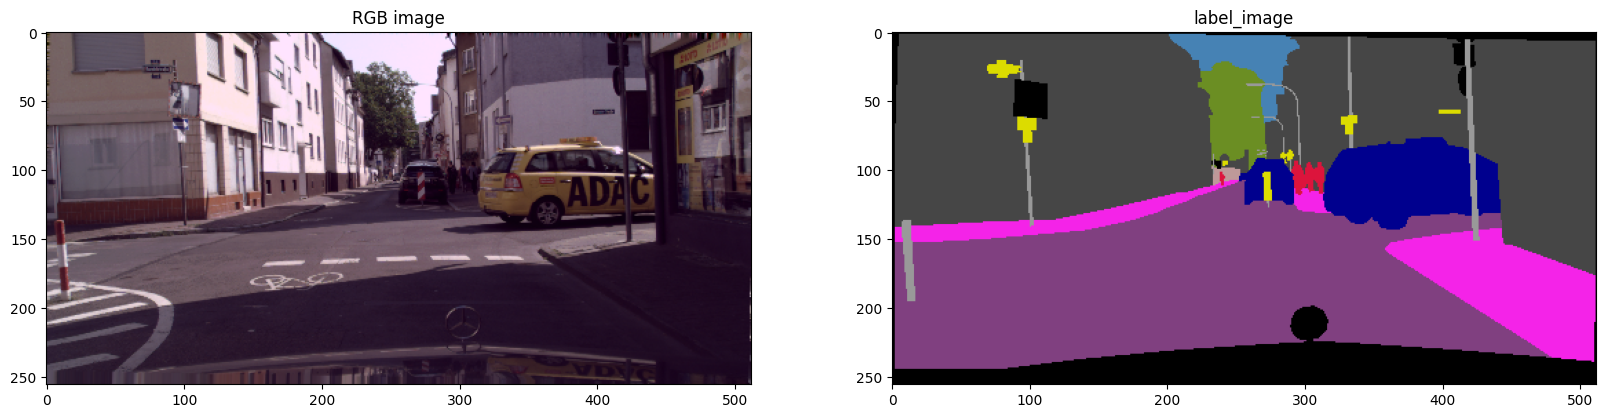

In [6]:
from scripts.helper import inverse_transform, decodeTarget        
        
source_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy() # From Normalized to RGB
colormapped_label_image = decodeTarget(label_image).astype('uint8')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 40))
ax1.imshow(source_image)
ax1.set_title("RGB image")
ax2.imshow(colormapped_label_image)
ax2.set_title("label_image")
plt.show()

## 2. Model

In [7]:
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

### 1. Baseline Model: 
The baseline model should be relatively simple and serve as a reference point for performance evaluation. A common choice for semantic segmentation baseline is the FCN (Fully Convolutional Network) or UNet due to their simplicity and effectiveness.

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128)
        self.conv3 = self.conv_block(128, 256)

        # Decoder (Expansive Path)
        self.upconv3 = self.conv_block(256, 128)
        self.upconv2 = self.conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        conv2 = self.conv2(F.max_pool2d(conv1, kernel_size=2, stride=2))
        conv3 = self.conv3(F.max_pool2d(conv2, kernel_size=2, stride=2))

        # Decoder
        upconv3 = F.interpolate(conv3, scale_factor=2, mode='bilinear', align_corners=True)
        upconv3 = self.upconv3(upconv3)
        upconv2 = F.interpolate(upconv3 + conv2, scale_factor=2, mode='bilinear', align_corners=True)
        upconv2 = self.upconv2(upconv2)
        upconv1 = F.interpolate(upconv2 + conv1, scale_factor=2, mode='bilinear', align_corners=True)
        
        # Final convolution for segmentation map
        segmentation_map = self.final_conv(upconv1)
        
        return segmentation_map


### 2. State of the art Model

In [9]:
# import model class
from scripts.models.segmentation import deeplabv3_resnet50

# load pretrained model and transfer to CPU, set to inference mode
fp32_model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES)
fp32_model.load_state_dict(torch.load('weightFiles/deeplabv3_r50.pt', map_location=cpu_device))
fp32_model.eval();

# evaluate performance on Test set
from scripts.helper import evaluteOnTestData
fp32_model_metric = evaluteOnTestData(fp32_model, None, cpu_device, test_dataloader, meanIoU, 'meanIoU', 'fp32_model_deepLabv3')
# fp32_model_metric = evaluteOnTestData(fp32_model, None, gpu_device, test_dataloader, meanIoU, 'meanIoU', 'fp32_model_deepLabv3')
print(f"\nfp32_model has {round(fp32_model_metric,3)} IoU metric on test data")

100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


fp32_model has 0.559 IoU metric on test data


### 3. Custom model: 
New Model with Quantization, Pruning, and Knowledge Distillation, developing a custom model that can be optimized through techniques like quantization, pruning, and knowledge distillation. We can start with a baseline architecture (e.g., modified UNet) and apply these techniques to reduce model size while maintaining or improving accuracy.

In [10]:
class CustomUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=20, teacher_model=None):
        super(CustomUNet, self).__init__()

        # Define your custom architecture (similar to UNet)
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128)
        self.conv3 = self.conv_block(128, 256)

        self.upconv3 = self.conv_block(256, 128)
        self.upconv2 = self.conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        self.teacher_model = teacher_model  # Teacher model for knowledge distillation

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        conv2 = self.conv2(F.max_pool2d(conv1, kernel_size=2, stride=2))
        conv3 = self.conv3(F.max_pool2d(conv2, kernel_size=2, stride=2))

        # Decoder
        upconv3 = F.interpolate(conv3, scale_factor=2, mode='bilinear', align_corners=True)
        upconv3 = self.upconv3(upconv3)
        upconv2 = F.interpolate(upconv3 + conv2, scale_factor=2, mode='bilinear', align_corners=True)
        upconv2 = self.upconv2(upconv2)
        upconv1 = F.interpolate(upconv2 + conv1, scale_factor=2, mode='bilinear', align_corners=True)
        
        # Final convolution for segmentation map
        segmentation_map = self.final_conv(upconv1)

        if self.teacher_model is not None:
            with torch.no_grad():
                teacher_output = self.teacher_model(x)
            return segmentation_map, teacher_output

        return segmentation_map
